## Isetbio: the cone mosaic

A starting point for isetbio that guides the user quickly through generating a stimulus and computing a scene, optical image, cone absorptions and photocurrent. Many of the implementation details are kept inside functions. The user is encouraged to go through the tutorials in the Scene, Optics and RGC folders for more detail.

This tutorial is based on the experiments conducted in "Chromatic detection from cone photoreceptors to V1 neurons to behavior in rhesus monkeys", Charles A Hass, Juan M Angueyra, Zachary Lindbloom-Brown, Fred Rieke,
   Gregory D Horwitz, Journal of Vision, 2015.
   
Gabor color opponent stimuli are generated and presented to an isetbio cone mosaic. The photocurrent is computed, and a simple classification task is run to test detection accuracy. This is the first step in a computation of detection threshold.

In [1]:
% Build a Gabor stimulus of one frame

% Choose color opponent pair, from 1-4
params.colorInd = 1;
% Choose contrast of Gabor
params.contrast =1;
% Choose number of time steps
params.nSteps = 1;

% Generate the Gabor stimulus
iStim = ieStimulusGaborColor(params)

Computing cone isomerizations:    

iStim = 

      params: [1x1 struct]
     display: [1x1 struct]
       scene: [1x1 struct]
    sceneRGB: [4-D double]
          oi: [1x1 struct]
     cMosaic: [1x1 coneMosaic]


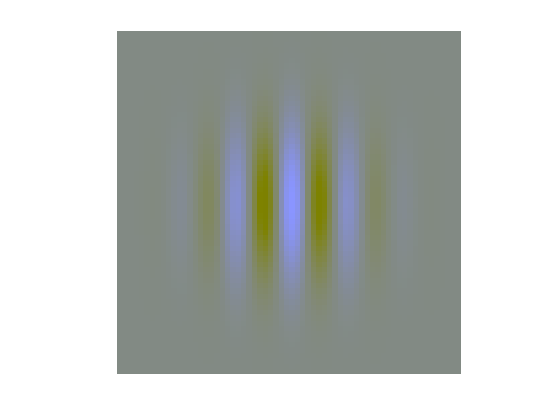

In [3]:

% Show the isetbio scene
figure; 
sceneShowImage(iStim.scene);


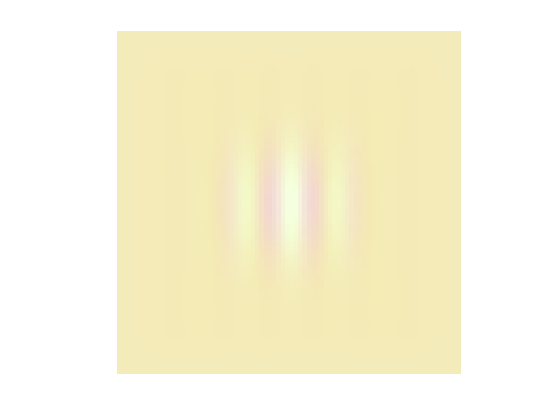

In [4]:
% Show the isetbio optical image
figure;
oiShowImage(iStim.oi);

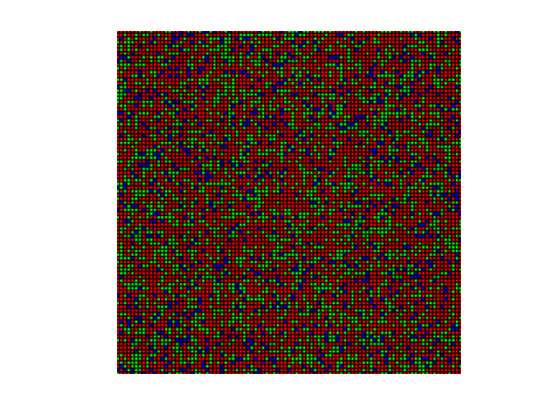

In [5]:

% Show the cone mosaic
h1 = figure;
iStim.cMosaic.plot('conemosaic','hf',h1);

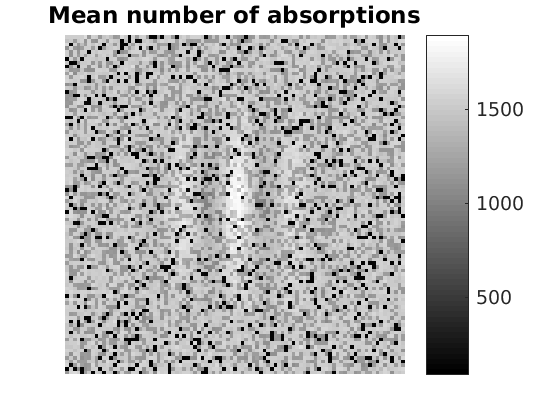

In [6]:

% Show the mean photon absorptions of the mosaic
h2 = figure;
iStim.cMosaic.plot('mean absorptions','hf',h2);

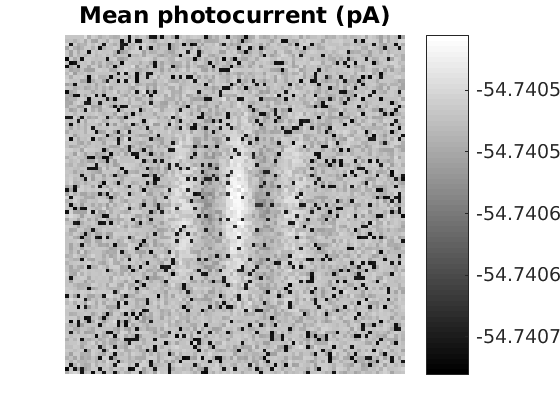

In [7]:
% Show the mean photocurrent of the mosaic
h3 = figure;
iStim.cMosaic.plot('mean current','hf',h3);


In [8]:
%% Specify parameters for contrast values and noise repititions

% Compute the response across each cone type.  For each noise
% iteration (a) project the time series of each cone onto the
% expected mean time series, (b) take that mean value for each cone
% type to give the mean on that particular noise iteration. The
% projection step eliminates signals that are orthogonal to the
% expected linear temporal response.  The expected response is
% derived by running the simulation with the noise flag set to 0
% (photon noise only). This calculation produces an (L, M, S)
% triplet for each noise iteration.  This is a specific
% implementation of an ideal observer; see the paper for details.
% This computation is carried out internally by the function 
% 'matchedConeResponse'.

nContrast   = 2;                       % number of contrasts to test
maxContrast = linspace(0,1,nContrast); % only contrasts [0 1] for nContrast=2

noiseIterations = 100;    % more iterations will improve accuracy but take longer!
pooledData      = cell(1,nContrast);
rocArea         = zeros(1,nContrast);

% Generate 60 frames of stimulus and response at 100% contrast
colorInd = 2;
contrastInd = [nContrast];

params.colorInd = colorInd;
params.contrast = maxContrast(contrastInd);
params.nSteps = 60;
iStim1 = ieStimulusGaborColor(params);

pooledData{contrastInd} = matchedConeResponse(iStim1.cMosaic, noiseIterations);

Computing cone isomerizations:


In [9]:
%% Generate 60 frames of stimulus and response at 0% contrast
colorInd = 2;
contrastInd = [1];

params.colorInd = colorInd;
params.contrast = maxContrast(contrastInd);
params.nSteps = 60;
iStim2 = ieStimulusGaborColor(params);

pooledData{contrastInd} = matchedConeResponse(iStim2.cMosaic, noiseIterations);

Computing cone isomerizations:


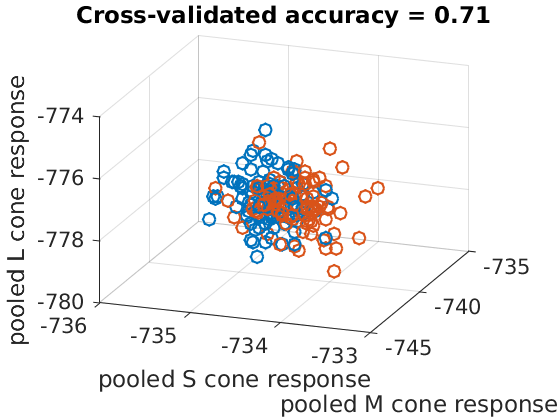

In [10]:
%% Plot the pooled noisy responses in LMS space and learn a linear classifer
figure;
hold on; grid on; view(20,25);
scatter3(pooledData{1}(:,1),pooledData{1}(:,2),pooledData{1}(:,3))
scatter3(pooledData{2}(:,1),pooledData{2}(:,2),pooledData{2}(:,3))
xlabel('pooled S cone response'); ylabel('pooled M cone response'); zlabel('pooled L cone response');

% The pooled response for the cone array at
% each contrast level is compared to the pooled response for no
% Gabor present using a linear SVM, and the cross-validated
% accuracy of the linear SVM is calculated.
m1 = fitcsvm([pooledData{1}; pooledData{2}], [ones(noiseIterations,1); -1*ones(noiseIterations,1)], 'KernelFunction', 'linear');
% Calculate cross-validated accuracy based on model:
cv = crossval(m1,'kfold',5);
rocArea(contrastInd) = 1-kfoldLoss(cv)';
title(sprintf('Cross-validated accuracy = %0.2f',1-kfoldLoss(cv)));